In [2]:
import numpy as np
import random
import pprint
random.seed(123)

In [3]:
class JackEnv:
    
    def __init__(self):
        self.num_episodes = 500000
        self.pack = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10 ,10, 10]
        self.actions = {'hit': 0, 'stick': 1}
    
    def pick_card(self):
        return np.random.choice(self.pack)
    
    def generate_hand(self):
        cards = [np.random.choice(self.pack), np.random.choice(self.pack)]
        values = cards[:]
        for i, card in enumerate(cards):
            if card == self.pack[0]:
                if sum(values) + 10 <= 21:
                    values[i] = 11
        return cards, values

    def check_natural(self, player):
        if sum(player) == 21:
            return True
        else: 
            return False
    
    def usable_ace(self, player_cards, player_values):
        ace = False
        for index, card in enumerate(player_cards):
            if card == 1:
                if player_values[index] == 11:
                    ace = True
        return ace
    
    def get_action_from_policy(self, cur_sum):
#         print('Action from policy', cur_sum)
        if cur_sum >= 20:
            return self.actions['stick']
        else:
            return self.actions['hit']
        
    def add_card_to_hand(self, card, player_cards, player_values):
#         print('Received card', card, player_cards)
        
        player_cards.append(card)
        if card != 1:
            
            player_values.append(card)
        else:
            if sum(player_values) + 11 <= 21:
                player_values.append(11)
            else:
                player_values.append(1)
#         print('Added to hand ', player_cards)
        return player_cards, player_values
    
    def check_score(self, player_values, dealer_values):
        player_diff = 21  - sum(player_values)
        dealer_diff = 21 - sum(dealer_values)
#         print(player_diff, dealer_diff)
        if player_diff < dealer_diff:
            return 1
        
        elif player_diff == dealer_diff:
            return 0
        else:
            return -1
    
    def change_ace(self, player_cards, player_values):
        
        for i in range(len(player_cards)):
            if player_cards[i] == 1 and sum(player_values) > 21:
                if player_values[i] == 11:
                    player_values[i] = 1
                    return True
        
        return False
    
        
    
    def generate_episodes(self):
        player_cards, player_values = self.generate_hand()
        dealer_cards, dealer_values = self.generate_hand()
        
#         print('Player init', player_cards, 'player values', player_values)
#         print('Dealer init', dealer_cards, 'Dealer values', dealer_values)
        states = []
        rewards = []
        actions = []
        done = False
#         usable_ace = True
#         cur_sum = sum(player_values)
#         cur_ace = self.usable_ace(player_cards, player_values)
#         cur_deal = dealer_cards[0]
        

        iter = 0
        
        
        while not done:
            cur_sum = sum(player_values)
            cur_ace = self.usable_ace(player_cards, player_values)
            cur_deal = dealer_cards[0]
            
            states.append((cur_sum, cur_ace, cur_deal))
            action = self.get_action_from_policy(cur_sum)
            actions.append(action)
            
            if action == self.actions['hit']:
                new_card = self.pick_card()
                player_cards, player_values = self.add_card_to_hand(new_card, player_cards, \
                                                                    player_values)
#                 print('added card', new_card, player_cards)
                if sum(player_values) > 21:
                    if 1 in player_cards:
                        changed = self.change_ace(player_cards, player_values)
                        if changed:
                            cur_ace = self.usable_ace(player_cards, player_values)
                    if sum(player_values) > 21:
                        
                        done = True
                        reward = -1
                        rewards.append(reward)
                        break
                    else:
                        done = False
                        reward = 0
                else:
                    done = False
                    reward = 0
            elif action == self.actions['stick']:
                done = True
                while sum(dealer_values) < 17:
                    next_d_card = self.pick_card()
                    dealer_cards, dealer_values = self.add_card_to_hand(next_d_card,\
                                                        dealer_cards, dealer_values)
                
                if sum(dealer_values) > 21:
                    
                    reward = 1
                    rewards.append(reward)
                    break
                else:
                    reward =  self.check_score(player_values, dealer_values)
            rewards.append(reward)
#             cur_sum = sum(player_values)
#             cur_ace = self.usable_ace(player_cards, player_values)
#             cur_deal = dealer_cards[0]
#             states.append((cur_sum, cur_ace, cur_deal))
            iter += 1
        
        return states, rewards, actions, (player_cards, player_values), \
                    (dealer_cards, dealer_values)

In [4]:
bj = JackEnv()
states , rewards, actions, player_info, dealer_info = bj.generate_episodes()
print('States', states)
print('Actions', actions)
print('Rewards', rewards)
print(len(states), len(actions), len(rewards))
print('Player Cards', player_info[0], 'Player Values', player_info[1])
print('Dealer Cards ', dealer_info[0], 'Dealer Values', dealer_info[1])


States [(18, False, 9), (19, False, 9), (21, False, 9)]
Actions [0, 0, 1]
Rewards [0, 0, 1]
3 3 3
Player Cards [10, 8, 1, 2] Player Values [10, 8, 1, 2]
Dealer Cards  [9, 10] Dealer Values [9, 10]


Ex 5.4 

Using mean and count to update the return 

In [5]:
global_dict = {}
for episode in range(500000):
    states , rewards, actions, player_info, dealer_info = bj.generate_episodes()
    G = 0
    if episode % 100000== 0:
        print(episode)
        
    for i in reversed(range(len((states)))):
        G += rewards[i]
        if states[i] not in global_dict.keys():
            global_dict[states[i]] = [G, 1]
        else:
            global_dict[states[i]][0] = (global_dict[states[i]][0] * global_dict[states[i]][1] \
                                        + G) / (global_dict[states[i]][1] + 1)
            global_dict[states[i]][1] += 1
        #         G = G + rewards[-(i+1)]
        # 9 , 8 ,7 ...
        
        

0
100000
200000
300000
400000


In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [7]:
def get_value(dict_val, val):
    if val not in dict_val.keys():
        return [0,0]
    else:
        return dict_val[val]

def plot_graph(dict_val, usable_ace=False):
    states = []
    values = []
    X = []
    Y = []
    Z = []
    init_states = list(dict_val.keys())
#     print(init_states)
    for i in range(len(dict_val.keys())):
        if init_states[i][1] == usable_ace and init_states[i][0] >= 12:
            states.append(init_states[i])
            values.append(dict_val[init_states[i]])
    x_range = np.arange(11, 22) # player sums 
    y_range = np.arange(1, 11) # visible dealer card 
    X, Y = np.meshgrid(x_range, y_range)

    Z = np.array([get_value(dict_val, (x, usable_ace, y))[0] for x,y in zip(np.ravel(X), np.ravel(Y))])\
    .reshape(X.shape)
    # corresponding values
#     print(Z.shape) 

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,Z)
    ax.set_title(usable_ace)
    ax.set_xlabel('Player sum')
    ax.set_ylabel('Dealer card')
    ax.set_zlabel('Value')
    plt.show()


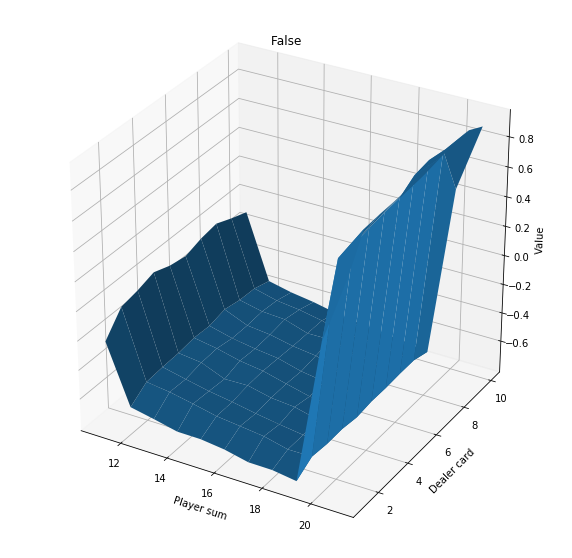

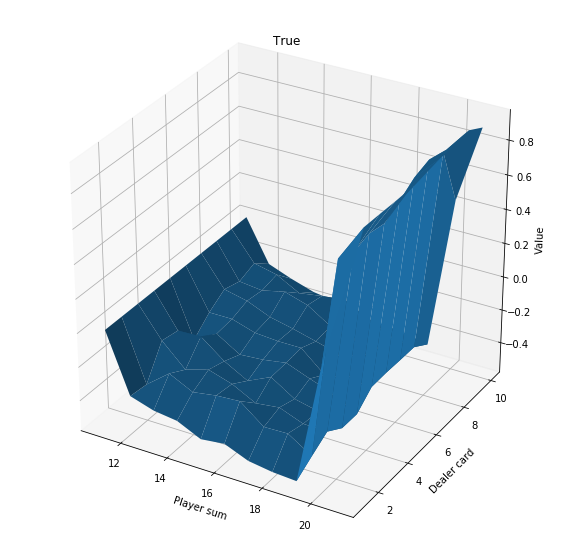

In [8]:
plot_graph(global_dict)
plot_graph(global_dict, True)

# similarly plot for 10k

In [9]:
global_dict = {}
for episode in range(10000):
    states , rewards, actions, player_info, dealer_info = bj.generate_episodes()
    G = 0
    if episode % 1000== 0:
        print(episode)
        
    for i in reversed(range(len((states)))):
        G += rewards[i]
        if states[i] not in global_dict.keys():
            global_dict[states[i]] = [G, 1]
        else:
            global_dict[states[i]][0] = (global_dict[states[i]][0] * global_dict[states[i]][1] \
                                        + G) / (global_dict[states[i]][1] + 1)
            global_dict[states[i]][1] += 1
        #         G = G + rewards[-(i+1)]
        # 9 , 8 ,7 ...
        
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


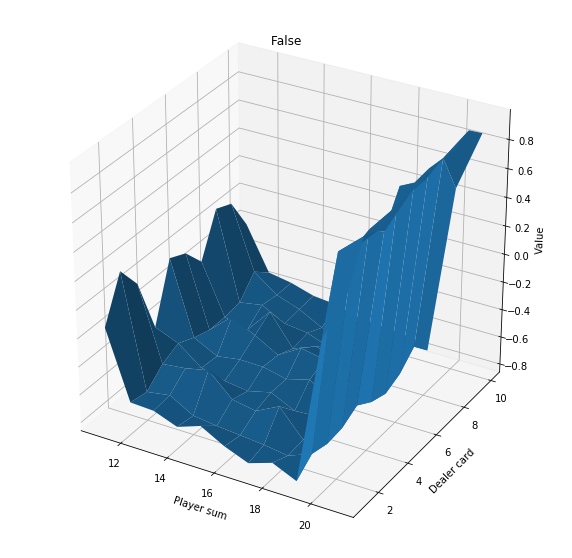

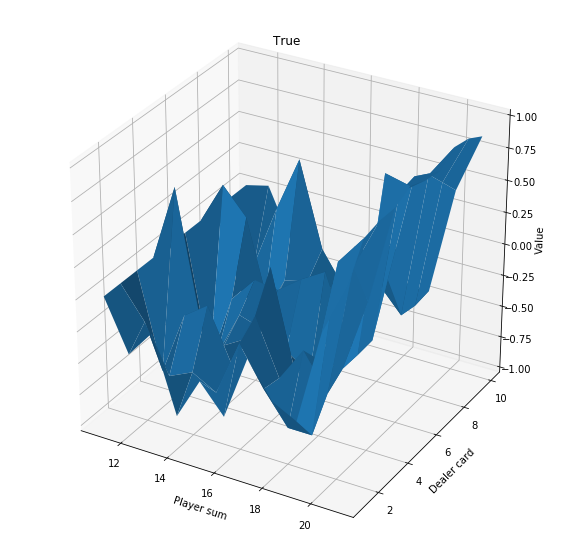

In [10]:
plot_graph(global_dict)
plot_graph(global_dict, True)